In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [0]:
# fix random seed for reproducibility
np.random.seed(7)

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# date parser
parser = lambda date: pd.to_datetime(date, format='%d-%m-%y %H:%M')

# load the dataset
dataframe = pd.read_csv(
    'drive/My Drive/EVANS-EFCO_final_clean_with_2018.csv', parse_dates=[0],
    index_col=[0], date_parser=parser, engine='python'
)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [39]:
# split into train and test sets
train_size = int(len(dataset[0:17543])) # dataset[0:17543] - from 2016-01-01 00:00:00 to 2017-12-31 23:00:00
train, test = dataset[0:train_size,:], dataset[train_size+1:len(dataset),:]  # whole of 2018
print(len(train), len(test))

17543 8760


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
trainY.shape, trainX.shape, testY.shape, testX.shape

((17541,), (17541, 1, 1), (8758,), (8758, 1, 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mape'])

model.summary()

model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=1)

# save model
model.save('power-load-stacked-lstm-model.h5')

In [0]:
# load model
model = load_model('drive/My Drive/power-load-stacked-lstm-model.h5')

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [47]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.07 RMSE


In [0]:
def mean_average_error(actual, predicted):
    mae_score = (actual - predicted).sum() / len(actual)
    print('Prediction Mean Average Error (MAE) Score: {0:.2f}'.format(mae_score))

In [0]:
def root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual_data, predicted_data))
    print('Prediction Root Mean Square Error (RMSE) Score: {0:.2f}%'.format(rmse_score))

In [0]:
actual_data = scaler.inverse_transform(dataset[:len(testPredict)])
predicted_data = scaler.inverse_transform(testPredict)

In [51]:
# RMSE score for prediction
root_mean_square_error(actual_data, predicted_data)

Prediction Root Mean Square Error (RMSE) Score: 49.92%


In [52]:
# MAE
mean_average_error(actual_data, predicted_data)

Prediction Mean Average Error (MAE) Score: 4.63


In [0]:
%matplotlib inline

In [0]:
import seaborn as sns

from scipy import stats

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict

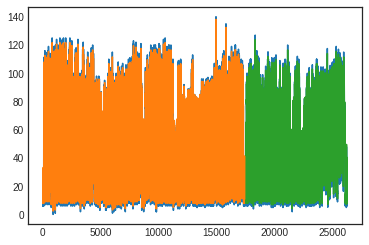

In [68]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(scaler.inverse_transform(trainPredictPlot))
plt.plot(scaler.inverse_transform(testPredictPlot))
plt.show()

In [0]:
def normalize_predicted_dataset(payload, dataframe):
    date_index = dataframe.index
    predicted = pd.DataFrame(scaler.inverse_transform(payload))
    predicted = predicted.replace(np.nan, 0.0)
    predicted['Date'] = date_index
    predicted = predicted.set_index('Date')
    predicted.columns = ['Energy Consumption']
    return predicted[:-1]

In [0]:
predicted_data = normalize_predicted_dataset(testPredictPlot, dataframe)

In [0]:
def plot_monthly(test_data, prediction):
    month_names = [
        'January', 'February', 'March', 'April', 'May', 'June','July',
        'August', 'September', 'October', 'November', 'December'
    ]
    month_index = [
        '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
        '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'
    ]
    month = int(input('Enter month: e.g 1 \n'))

    %matplotlib inline
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots()
    axis.plot(test_data[month_index[month-1]], label='Actual Consumption')
    axis.plot(prediction[month_index[month-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Datetime", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title("Energy Consumption, " + month_names[month-1] +",2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


In [0]:
def plot_seasonal(test_data, prediction):
    season_names = [
        'Long Rainy Season', 'Short Dry Season',
        'Short Rainy Season', 'First Half Of Long Dry Season',
        'Second Half Of Long Dry Season'
    ]
    season_index = [
        '2018-03:2018-07', '2018-08', '2018-09:2018-10-21',
        '2018-01:2018-02', '2018-10-22:2018-12'
    ]
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib inline
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots()
    if ':' in season_index[season-1]:
        index_list = season_index[season-1].split(':')
        axis.plot(test_data[index_list[0]:index_list[1]], label='Actual Consumption')
        axis.plot(prediction[index_list[0]:index_list[1]], label='Predicted Consumption', c='orange')
    else:
        axis.plot(test_data[season_index[season-1]], label='Actual Consumption')
        axis.plot(prediction[season_index[season-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Datetime", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title(season_names[season-1] +",2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


In [0]:
%matplotlib inline

Enter month: e.g 1 
1


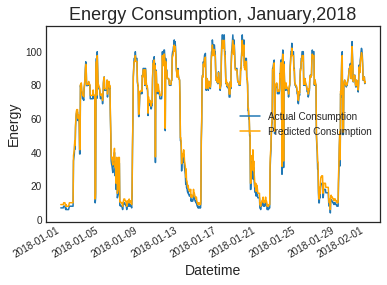

In [74]:
# plot_monthly(dataframe[:'2018-09-24'], predicted_data)
plot_monthly(dataframe, predicted_data)


        1. Long Rainy Season 	 2. Short Dry Season
        3. Short Rainy Season 	 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    4


<IPython.core.display.Javascript object>


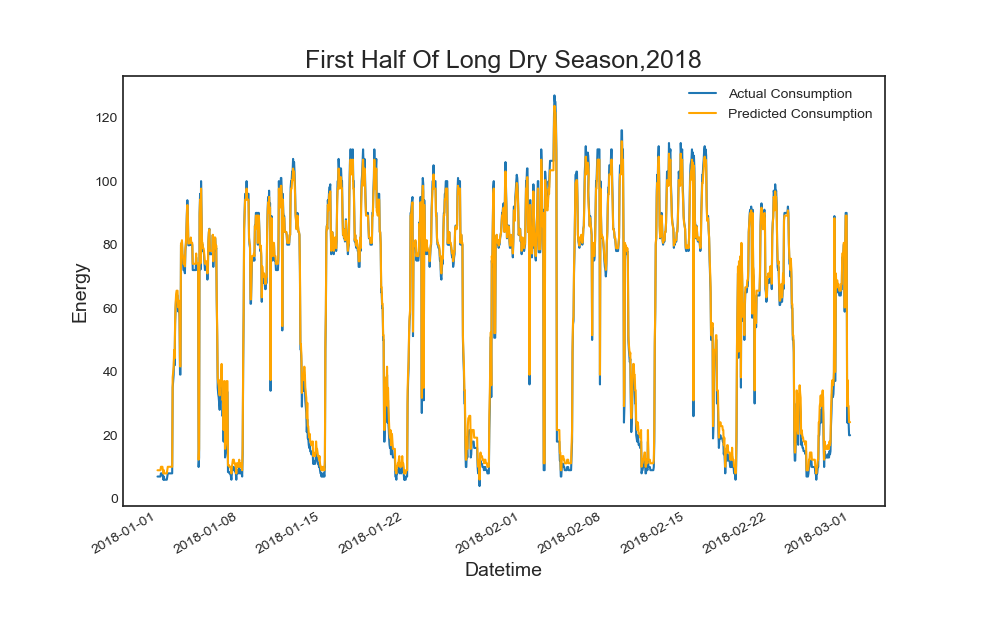

In [0]:
# plot_seasonal(dataframe[:'2018-09-24'], predicted_data)
plot_seasonal(dataframe, predicted_data)